In [17]:
'''
version 02 is for testing the new feature of direct injection of y
'''

'\nversion 02 is for testing the new feature of direct injection of y\n'

In [18]:
# load a matrix from a space-separated file and show it as an image
import sys
sys.path.append('/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/')
sys.path.append('/homes/ar2342/one_more_dir/contextual_frogs/')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from optimise_clnn import load_subject_data
from memory_upd_utils import polarity, extract_mem_updates
from model_utils import eval_ys, remove_gen, nans2none, force_model_params
from models import LegacyElboGenerativeModelTop,ElboGenerativeModelTop, ElboGenerativeModelDualRate
from types import SimpleNamespace
import copy
from optimise_clnn import load_subject_data


In [19]:
def load_adaptation_trace(file_path): 
        df = pd.read_csv(file_path)
        arr = df.Adaptation.to_numpy()
        return arr

In [20]:
LOSS_IS_PER_SAMPLE = False
result_root = '/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/'
coin_bics_path = '/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/coin_bics.txt'
paradigm_ = {k: 'evoked' if k <= 8 else 'spontaneous' for k in range(1,17)}
coin_bics = np.loadtxt(coin_bics_path)
# exp_datasets = [ load_adaptation_trace(f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_{paradigm_[i]}_recovery_participant{(i-1)%8+1}.csv') for i in range(1,17)]
experimental_data = {}
loss_traces= {}
output_traces= {}
prior_out_batch = {}
posterior_out_batch = {}
for i in range(1,25): 
    experimental_data[i] = load_subject_data(f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_memory_updating_participant{i}.csv')


In [21]:
'''load model'''

import copy


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = SimpleNamespace(model='default',
                       enable_q_scale_tuning=True,
                       assume_opt_output_noise=True, 
                       enable_qlpf=True,
                       enable_ylpf=False,
                       enable_elpf=True,
                       noise_injection_node='u',
                       model_tie_lr_weight_decay=True,
                       bs=24,
                       zzz_legacy_init=False,
                       enable_output_scale_tuning=True,
                       enable_u_feedback_scale_tuning=True,
                       enable_direct_injection = True,
                       n=2048)

model   =  ElboGenerativeModelTop(device=device, args=args)

In [22]:
def print_params():
    for this_param in model.named_parameters():
        print(this_param)

In [ ]:
forced_params = {'log_learning_rate_decay': -20., 
                 'sigma_x': 1e-7, 
                 'log_learning_rate': -10.0,
                 'sp_weight_decay': -1000.0,
                 'output_scale': 1.0,
                 'u_feedback_scale': 1.0,
                 'sigma_b': 1.0,
                 'q_scale': 1.0,
                 'tauelpf_m1': -1000.0,
                 'tauqlpf_m1': -1000.0,
                 'direct_injection_scale': 0.1}

force_model_params(model, forced_params)
# for name, param in model.named_parameters():
#     if name in forced_params:
#         print(f'Forcing parameter {name} to value {forced_params[name]}')
#         param.data.fill_(forced_params[name])

Forcing parameter log_learning_rate to value -10.0
Forcing parameter log_learning_rate_decay to value -20.0
Forcing parameter sigma_b to value 1.0
Forcing parameter output_scale to value 1.0
Forcing parameter u_feedback_scale to value 1.0
Forcing parameter sp_weight_decay to value -1000.0
Forcing parameter q_scale to value 1.0
Forcing parameter sigma_x to value 1e-07
Forcing parameter tauqlpf_m1 to value -1000.0
Forcing parameter tauelpf_m1 to value 1.0
Forcing parameter direct_injection_scale to value 0.1


In [34]:
print_params()

('log_learning_rate', Parameter containing:
tensor([-10.], device='cuda:0', requires_grad=True))
('log_learning_rate_decay', Parameter containing:
tensor([-20.], device='cuda:0', requires_grad=True))
('sigma_b', Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True))
('output_scale', Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True))
('u_feedback_scale', Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True))
('sp_weight_decay', Parameter containing:
tensor([-1000.], device='cuda:0', requires_grad=True))
('q_scale', Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True))
('sigma_x', Parameter containing:
tensor([1.0000e-07], device='cuda:0', requires_grad=True))
('tauqlpf_m1', Parameter containing:
tensor([-1000.], device='cuda:0', requires_grad=True))
('tauelpf_m1', Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True))
('direct_injection_scale', Parameter containing:
tensor([0.1000], device='cu

In [35]:
#simulate all the models with 
ts  = [experimental_data[i][1].shape[0] for i in experimental_data]
tmax = max(ts)
def pad(arr, tmax):
    pad_width = tmax - arr.shape[0]
    if pad_width > 0:
        arr = np.pad(arr, (0, pad_width), mode='constant', constant_values=0.)
    return arr
ys = torch.tensor([pad(experimental_data[i][1], tmax) for i in experimental_data], device=device, requires_grad=False, dtype=torch.float32)
qs = torch.tensor([pad(experimental_data[i][2], tmax) for i in experimental_data], device=device, requires_grad=False)#, dtype=torch.double)
ys = ys.transpose(0,1)  #shape (trials, subjects)
qs = qs.transpose(0,1)  #shape (trials, subjects)
# preds[i] = eval_ys(model, nans2none(ys), args, qs=qs)
preds_ = eval_ys(model, ys, args, qs=qs)

preds = {i: preds_[:ts[i-1], i-1] for i in range(1,25)}  #shape (subjects, trials)



In [36]:
# grid_sweeps = { 
#                  'log_learning_rate': [-6, -7, -8.0, -9, -10],
#                  'sigma_b': [0.1, 0.5 ,1.0, 2.0, 3.0],
#                  'q_scale': [0.1, 0.25, 0.5, 1, 2.0],
#                  'tauelpf_m1': [-1000, -1, 0, 1, 2, 3],
#                  'tauqlpf_m1': [-1000, -1, 0, 1, 2, 3],}
# grid_preds = {}
# for grid_param, grid_range in grid_sweeps.items():
#     grid_preds[grid_param] = []
#     for grid_value in grid_range:
#         force_model_params(model, {**forced_params, grid_param: grid_value})
#         preds_ = eval_ys(model, ys, args, qs=qs)
#         preds_per_params = {i: preds_[:ts[i-1], i-1] for i in range(1,25)}  #shape (subjects, trials)
#         grid_preds[grid_param].append(preds_per_params)

(930.0, 1160.0)

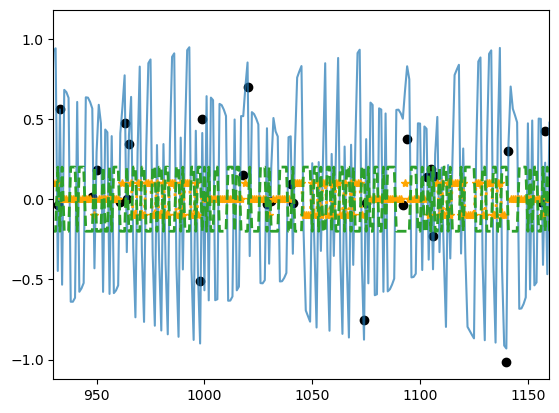

In [37]:
i = 3
plt.plot(experimental_data[i][0], 'o', label='experimental', color='black', linewidth=2)
# plt.plot(mean_as[i-1], '-x', label='prior mean a', color='blue', alpha=0.5)
plt.plot(preds[i], alpha=0.7)
plt.plot(0.1*experimental_data[i][1], ':*', label='experimental', color='orange', linewidth=2)
plt.plot(0.2*experimental_data[i][2], '--', label='experimental', color='tab:green', linewidth=2)
# plt.xlim([2100, 2150])
plt.xlim([930, 1160])

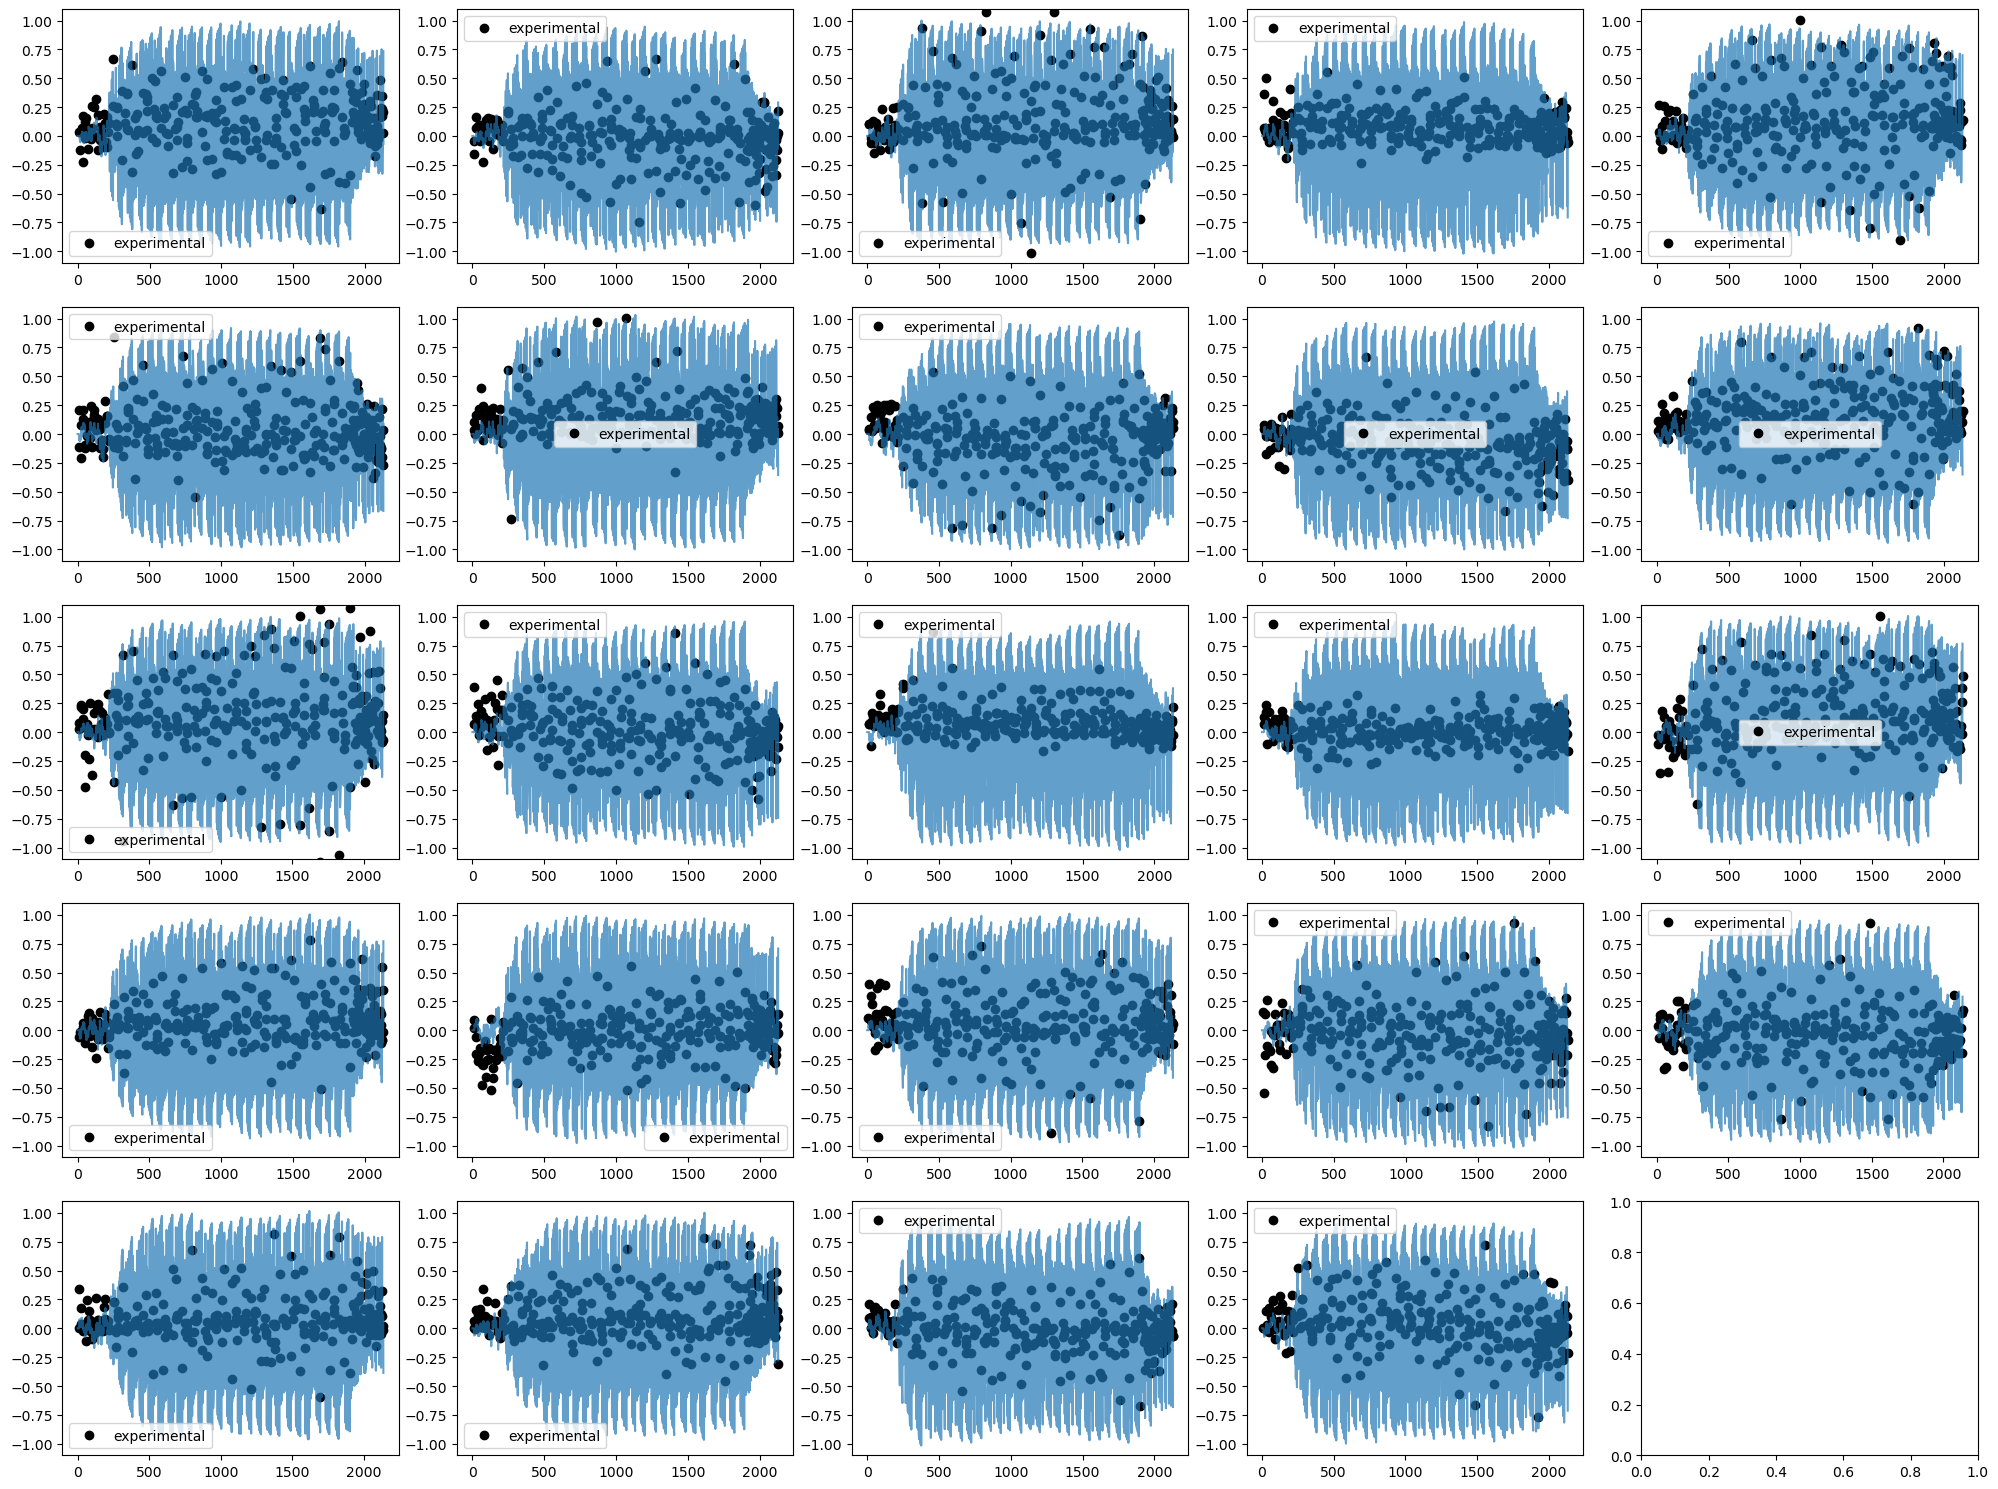

In [38]:
#plot output traces vs experimental data. subplot per run and line per seed
fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(1, 25):
    ax = axs[(i-1)//5, (i-1)%5]
    these_preds = np.mean(preds[i], axis=1) if len(preds[i].shape) > 1 else preds[i]
    ax.plot(experimental_data[i][0], 'o', label='experimental', color='black', linewidth=2)
    ax.plot(these_preds, alpha=0.7)
    ax.legend()
    ax.set_ylim([-1.1, 1.1])
plt.tight_layout()
plt.show()

In [39]:
outs = []
fit_outs = []
for i in range(1, 25):
            ys = experimental_data[i][1]
            qs = experimental_data[i][2]
            aa = experimental_data[i][0]
            outs.append(extract_mem_updates(ys, qs, aa,-32))
            # fit_outs.append(extract_mem_updates(ys, qs, mean_as[i-1],-32))
            these_preds = np.mean(preds[i], axis=1) if len(preds[i].shape) > 1 else preds[i]
            try:
                fit_outs.append(extract_mem_updates(ys, qs, these_preds,-32))
            except:
                # fit_outs.append(None)
                pass


(-0.2, 0.5)

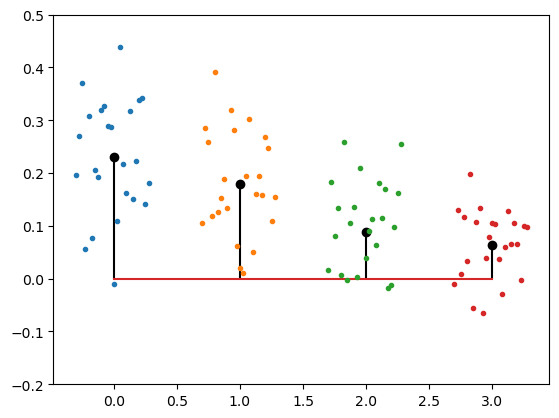

In [40]:
y_alignment = np.array([1,1,-1,-1])
plt.stem(y_alignment * np.mean(outs, axis=-1).mean(axis=0), 'xk')
for ii in range(4):
    xdata = -0.3+0.6/24*np.arange(24) + ii
    ydata = y_alignment[ii] * np.mean(outs, axis=-1)[:,ii]
    plt.plot(xdata, ydata,'.')
plt.ylim([-0.2, 0.5])

(-1.2, 1.4)

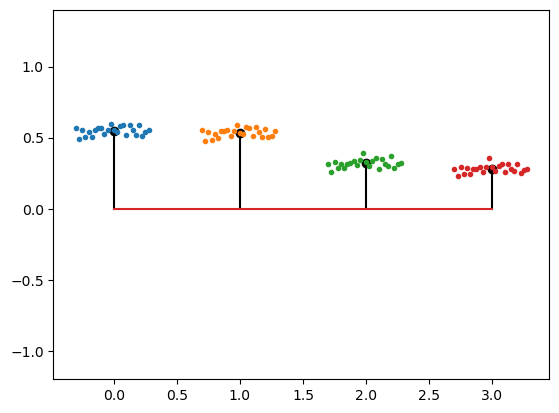

In [41]:
y_alignment = np.array([1,1,-1,-1])
plt.stem(y_alignment * np.mean(fit_outs, axis=-1).mean(axis=0), 'xk')
for ii in range(4):
    ydata = y_alignment[ii] * np.mean(fit_outs, axis=-1)[:,ii]
    xdata = -0.3+0.6/24*np.arange(len(ydata)) + ii
    plt.plot(xdata, ydata,'.')
plt.ylim([-1.2, 1.4])

NameError: name 'grid_preds' is not defined

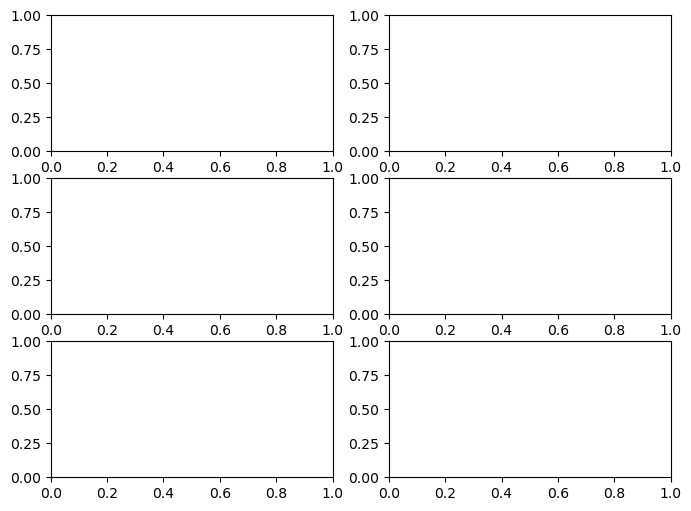

In [32]:
#plot resutls of gridiness sweeps
#only use means processed as above (so there are 4 averages that are output with x axis corresponding to parameter vals and no individual subject data)
#don't impose scale on the plots, insted use swept parameter for ticks
fig, ax_ = plt.subplots(3,2,figsize=(8, 6))
for kk, (grid_param, preds_per_sweep) in enumerate(grid_preds.items()):
    ax = ax_.flatten()[kk]
    mean_outs_list = []
    for grid_value, preds_per_params in zip(grid_sweeps[grid_param], preds_per_sweep):
        outs = []
        for i in range(1, 25):
            ys = experimental_data[i][1]
            qs = experimental_data[i][2]
            aa = experimental_data[i][0]
            these_preds = preds_per_params[i]
            try:
                outs.append(extract_mem_updates(ys, qs, these_preds,-32))
            except:
                # fit_outs.append(None)
                pass
        y_alignment = np.array([1,1,-1,-1])
        mean_outs = y_alignment * np.mean(outs, axis=-1).mean(axis=0)
        mean_outs_list.append(mean_outs)
    mean_outs_array = np.array(mean_outs_list)  #shape (num_grid_values, 4)
    ax.plot(mean_outs_array)
    ax.set_xticks(np.arange(len(grid_sweeps[grid_param])))
    ax.set_xticklabels([str(v) for v in grid_sweeps[grid_param]])
    #plot a dashed black vertical line at the index corresponding to the forced param value
    ax.axvline(x=grid_sweeps[grid_param].index(forced_params[grid_param]), color='black', linestyle='--')
    ax.set_xlabel(grid_param)
    ax.set_ylim([-0.5, 1.4])
    ax.legend()
    plt.tight_layout()

ax = ax_.flatten()[-1]
plt.stem(y_alignment * np.mean(fit_outs, axis=-1).mean(axis=0), 'xk')
for ii in range(4):
    ydata = y_alignment[ii] * np.mean(fit_outs, axis=-1)[:,ii]
    xdata = -0.3+0.6/24*np.arange(len(ydata)) + ii
    plt.plot(xdata, ydata,'.')
plt.ylim([-1.2, 1.4])
    # plt.show()

In [ ]:
ax

<Axes: >

In [ ]:
from scipy.stats import pearsonr

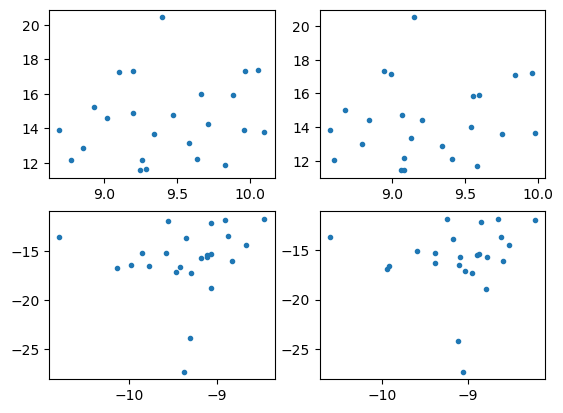

In [ ]:
_, ax = plt.subplots(2,2)
for ii in range(4):
    fit = np.mean(fit_outs, axis=-1)[:,ii]
    exp = np.mean(outs, axis=-1)[:,ii]
    ax[ii//2, ii%2].plot(fit, exp,'.')
    r, _ = pearsonr(fit, exp)
    # ax[ii//2, ii%2].set_title(f'Pearson r: {r:.2f}')

In [ ]:
fit_outs[0].shape

(4, 8)

In [ ]:
np.dtype(experimental_data[1][1][1])

dtype('float64')